# Import modules

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Tuning parameters

In [2]:
epochs = 50
learning_rate=0.025

In [3]:
batch_size = 128
num_classes = 10

# Data

## Plot image

In [4]:
def plot_images(x, y_true, y_pred=None, size=(5, 5)):
    assert len(x) == len(y_true) == size[0] * size[1]
    
    fig, axes = plt.subplots(size[0], size[1])
    fig.subplots_adjust(hspace=0.5, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        if x[i].shape[-1] == 1:
          ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
        else:
          ax.imshow(x[i])

        if y_pred is None:
            xlabel = "True: {0}".format(y_true[i].argmax())
        else:
            xlabel = "True: {0}, Pred: {1}".format(y_true[i].argmax(), 
                                                   y_pred[i].argmax())

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Load dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


## Reshaping the data

In [6]:
if len(x_train.shape) < 4:
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Applying One hot encoding for the data

In [8]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Show data

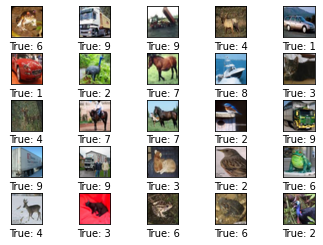

In [9]:
plot_images(x_train[:25], y_train[:25])

# Creating the DNN model

In [10]:
model = Sequential()

## Adding layers to the model

In [11]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softplus'))

## Visualization the model

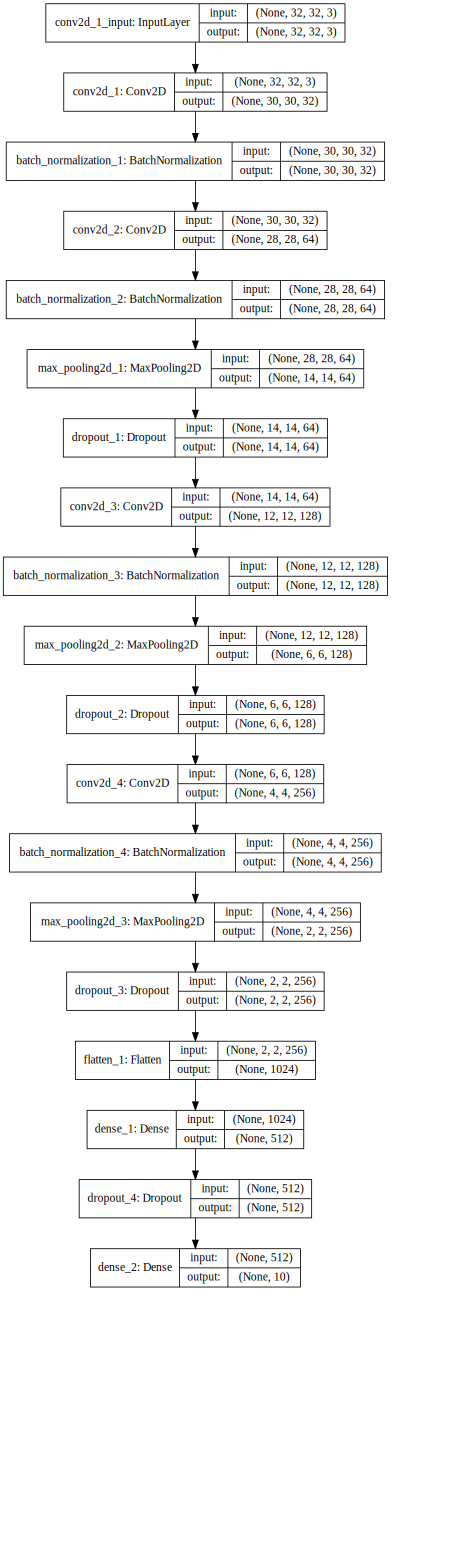

In [12]:
SVG(model_to_dot(model, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

## Optimizer

In [13]:
optimizer = keras.optimizers.SGD(lr=learning_rate)

## Compiling the model

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=optimizer, 
              metrics=['accuracy'])

## Training the model

In [15]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 30s 607us/step - loss: 1.7562 - accuracy: 0.3645 - val_loss: 2.3802 - val_accuracy: 0.2298
Epoch 2/50
50000/50000 [==============================] - 23s 468us/step - loss: 1.4406 - accuracy: 0.4887 - val_loss: 1.3729 - val_accuracy: 0.5153
Epoch 3/50
50000/50000 [==============================] - 23s 469us/step - loss: 1.2651 - accuracy: 0.5549 - val_loss: 1.2220 - val_accuracy: 0.5603
Epoch 4/50
50000/50000 [==============================] - 23s 468us/step - loss: 1.1419 - accuracy: 0.5977 - val_loss: 1.0394 - val_accuracy: 0.6288
Epoch 5/50
50000/50000 [==============================] - 23s 468us/step - loss: 1.0415 - accuracy: 0.6330 - val_loss: 1.0806 - val_accuracy: 0.6221
Epoch 6/50
50000/50000 [==============================] - 23s 469us/step - loss: 0.9793 - accuracy: 0.6538 - val_loss: 0.9547 - val_accuracy: 0.6654
Epoch 7/50
50000/50000 [==============================] 

## Evaulating the model

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.56697008330822
Test accuracy: 0.8237000107765198


## Prediction the model

In [17]:
y_pred = model.predict(x_test)

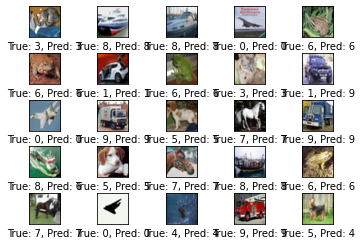

In [18]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred=y_pred[:25])

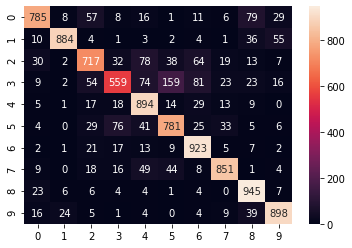

In [19]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')